In [1]:
import pandas as pd
import numpy as np

from keras.models import Model, load_model
from keras.layers import Input, LSTM, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint

import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
%cd /content/drive/MyDrive/Colab/Transliterate/

/content/drive/MyDrive/Colab/Transliterate


In [3]:
%ls

model.h5  model_plot_dec.png  model.png  players_with_hindi_names.json  s2s.h5


# Preprocessing Data

In [4]:
df = pd.read_json('players_with_hindi_names.json')

In [5]:
df.head()

,id,hindi_name,hindi_long_name,english_name,gender,date_of_birth,country_id,slug
0,90143,आर गुरबाज़,रहमानउल्लाह गुरबाज़,Rahmanullah Gurbaz,M,"{'year': 2001, 'month': 11, 'date': 28}",40,rahmanullah-gurbaz
1,54018,एम रिज़वान,मोहम्मद रिज़वान,Mohammad Rizwan,M,"{'year': 1992, 'month': 6, 'date': 1}",7,mohammad-rizwan
2,47686,एस मक़सूद,सोहेब मक़सूद,Sohaib Maqsood,M,"{'year': 1987, 'month': 4, 'date': 15}",7,sohaib-maqsood
3,53649,आर आर रुसो,राइली रुसो,"Rossouw, RR",M,"{'year': 1989, 'month': 10, 'date': 9}",3,rilee-rossouw
4,72393,एस हेटमायर,शिमरॉन हेटमायर,"Hetmyer, SO",M,"{'year': 1996, 'month': 12, 'date': 26}",4,shimron-hetmyer


In [6]:
input_list =  df['hindi_long_name'].tolist()
target_list =  df['english_name'].tolist()

In [7]:
print(input_list[0])
print(target_list[0])

रहमानउल्लाह गुरबाज़
Rahmanullah Gurbaz


In [8]:
def isEnglish(s):
  try:
      s.encode(encoding='utf-8').decode('ascii')
  except UnicodeDecodeError:
      return False
  else:
      return True

def get_mapping_words(input_list, target_list):
  # Build Vocabulary
  input_words = list()
  target_words = list()
  for input_word, target_word in zip(input_list, target_list):
    # there are some target words in hindi
    if isEnglish(target_word): 
      # there are 3 ways names are given
      # 1. Firstname lastname  Ex ('रहमानउल्लाह गुरबाज़', 'Rahmanullah Gurbaz')
      # 2. Lastname, Firstname Initials  Ex ('राइली रुसो', 'Rossouw, RR')
      # 3. Lastname. Firstname Initials  Ex ('राइली रुसो', 'Rossouw.RR')
      # if comma exists then discard initials
      if "," in target_word or "." in target_word:
        hln = input_word.split()[1]
        if "," in target_word:
          eln = target_word.lower().split(',')[0]
        else:
          eln = target_word.lower().split('.')[0]
        input_words.append(hln)
        target_words.append(eln)
      else:
        input_names = input_word.split()
        target_names = target_word.split()
        # For example - 'लिटन कुमार दास' != Liton Das, remove middle name
        if len(input_names) > len(target_names):
          del input_names[1] # delete middle name
        for idx in range(len(input_names)):
          hn = input_names[idx]
          en = target_names[idx].lower()
          input_words.append(hn)
          target_words.append(en)
  return input_words, target_words

In [9]:
input_words, target_words = get_mapping_words(input_list, target_list)

In [10]:
# verifying the data
print(input_words[20])
print(target_words[20])

शारजील
sharjeel


In [11]:
print(f"Total number of input words {len(input_words)}")
print(f"Total number of target words {len(target_words)}")

Total number of input words 2914
Total number of target words 2914


In [12]:
def build_vocab(input_words, target_words):
  input_vocab = set()
  target_vocab = set()
  for input_word, target_word in zip(input_words, target_words):
      input_vocab.update(set(input_word))
      target_vocab.update(set(target_word))
  return input_vocab, target_vocab

In [13]:
input_vocab, target_vocab = build_vocab(input_words, target_words)

In [14]:
# append start of word (^) and end of word tokens ($)
target_vocab.add('^')
target_vocab.add('$')

In [15]:
print(f"Total hindi characters {len(input_vocab)}")
print(f"Total english characters {len(target_vocab)}")

Total hindi characters 53
Total english characters 31


In [16]:
input_vocab = sorted(list(input_vocab))
target_vocab = sorted(list(target_vocab))

In [17]:
input_token_index = dict([(char, i) for i, char in enumerate(input_vocab)])
target_token_index = dict([(char, i) for i, char in enumerate(target_vocab)])

In [18]:
num_encoder_tokens = len(input_vocab)
num_decoder_tokens = len(target_vocab)

In [19]:
max_encoder_seq_length = max([len(txt) for txt in input_words])
max_decoder_seq_length = max([len(txt) for txt in target_words])
# for start & end of the word
max_decoder_seq_length += 1

In [20]:
print('Number of samples:', len(input_words))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 2914
Number of unique input tokens: 53
Number of unique output tokens: 31
Max sequence length for inputs: 13
Max sequence length for outputs: 16


In [21]:
encoder_input_data = np.zeros((len(input_words), max_encoder_seq_length, num_encoder_tokens), dtype='float32')
decoder_input_data = np.zeros((len(input_words), max_decoder_seq_length, num_decoder_tokens), dtype='float32')
decoder_target_data = np.zeros( (len(input_words), max_decoder_seq_length, num_decoder_tokens), dtype='float32')

In [22]:
print(f"encoder input shape {encoder_input_data.shape}")
print(f"decoder input shape {decoder_input_data.shape}")
print(f"decoder target shape {decoder_target_data.shape}")

encoder input shape (2914, 13, 53)
decoder input shape (2914, 16, 31)
decoder target shape (2914, 16, 31)


In [23]:
for i, (input_text, target_text) in enumerate(zip(input_words, target_words)):
  for t, char in enumerate(input_text):
    encoder_input_data[i, t, input_token_index[char]] = 1.0

  target_text_w_sow = '^' + target_text 
  for t, char in enumerate(target_text_w_sow):
    decoder_input_data[i, t, target_token_index[char]] = 1.0

  target_text_w_eow = target_text + '$'
  for t, char in enumerate(target_text_w_eow):
    decoder_target_data[i, t, target_token_index[char]] = 1.0

# Define Model

In [24]:
latent_dim = 256  # Latent dimensionality of the encoding space.

# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

In [25]:
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

In [26]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))

In [27]:
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [28]:
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [29]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 53)]   0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 31)]   0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 256), (None, 317440      input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 256),  294912      input_2[0][0]                    
                                                                 lstm[0][1]                   

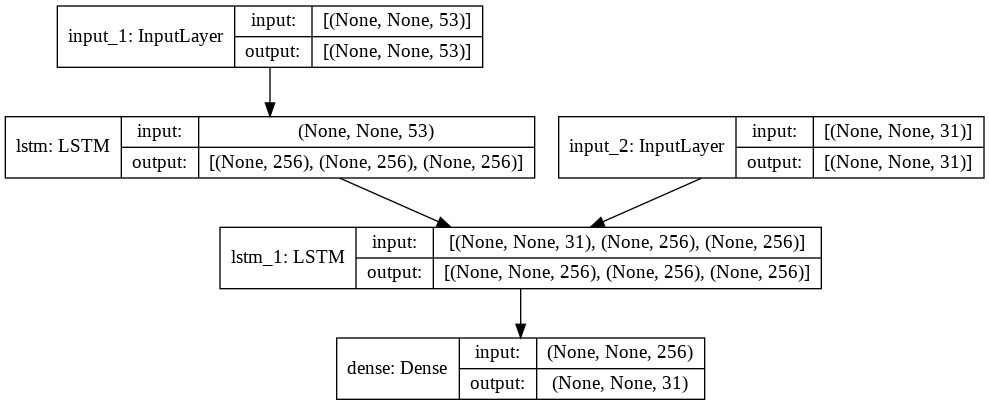

In [30]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

# Train

In [31]:
# Training
batch_size = 32  # Batch size for training.
epochs = 200  # Number of epochs to train for.

# Add callbacks:
# 'EarlyStopping' to stop training when the model is not enhancing anymore
# 'ModelCheckPoint' to always keep the model that has the best val_accuracy
model_save_filename = "model.h5"

def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

earlystopping_cb = EarlyStopping(patience=10, restore_best_weights=True)
mdlcheckpoint_cb = ModelCheckpoint(
    model_save_filename, monitor="val_accuracy", save_best_only=True
)
lrscheduler_cb = tf.keras.callbacks.LearningRateScheduler(scheduler)

model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.01), 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])


history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size, epochs=epochs,  validation_split=0.2, 
          callbacks=[earlystopping_cb, mdlcheckpoint_cb, lrscheduler_cb])

Epoch 1/200
73/73 [==============================] - 13s 130ms/step - loss: 1.2860 - accuracy: 0.0971 - val_loss: 1.1347 - val_accuracy: 0.0803
Epoch 2/200
73/73 [==============================] - 9s 119ms/step - loss: 1.1368 - accuracy: 0.1314 - val_loss: 1.0209 - val_accuracy: 0.1225
Epoch 3/200
73/73 [==============================] - 9s 118ms/step - loss: 0.9668 - accuracy: 0.1804 - val_loss: 0.8894 - val_accuracy: 0.1547
Epoch 4/200
73/73 [==============================] - 9s 121ms/step - loss: 0.8245 - accuracy: 0.2246 - val_loss: 0.7670 - val_accuracy: 0.2296
Epoch 5/200
73/73 [==============================] - 9s 119ms/step - loss: 0.6834 - accuracy: 0.2682 - val_loss: 0.7266 - val_accuracy: 0.2208
Epoch 6/200
73/73 [==============================] - 9s 117ms/step - loss: 0.5558 - accuracy: 0.3086 - val_loss: 0.5890 - val_accuracy: 0.2828
Epoch 7/200
73/73 [==============================] - 9s 118ms/step - loss: 0.4721 - accuracy: 0.3367 - val_loss: 0.5753 - val_accuracy: 0.287

In [32]:
# list all data in history
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


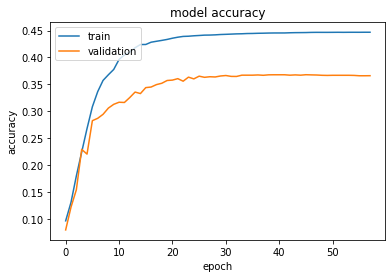

In [33]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

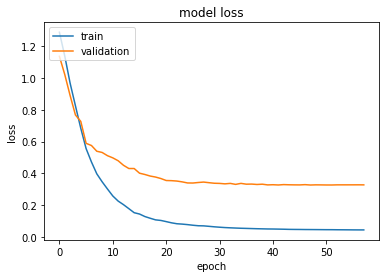

In [34]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [35]:
%ls -ltr

total 10643
-rw------- 1 root root  813709 Sep 14 22:38 players_with_hindi_names.json
-rw------- 1 root root 5006688 Sep 17 01:54 s2s.h5
-rw------- 1 root root   33486 Sep 17 17:16 model_plot_dec.png
-rw------- 1 root root   36092 Sep 17 17:20 model.png
-rw------- 1 root root 5006688 Sep 17 17:27 model.h5


In [36]:
!du -sh model.h5

4.8M	model.h5


# Inference

In [37]:
# Restore the model and construct the encoder and decoder.
model = load_model(model_save_filename)

In [38]:
# Predictions
encoder_inputs = model.input[0]  # input_1
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output  # lstm_1
encoder_states = [state_h_enc, state_c_enc]

encoder_model = Model(encoder_inputs, encoder_states)

decoder_inputs = model.input[1]  # input_2
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)

decoder_states = [state_h_dec, state_c_dec]

decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)

In [39]:
# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

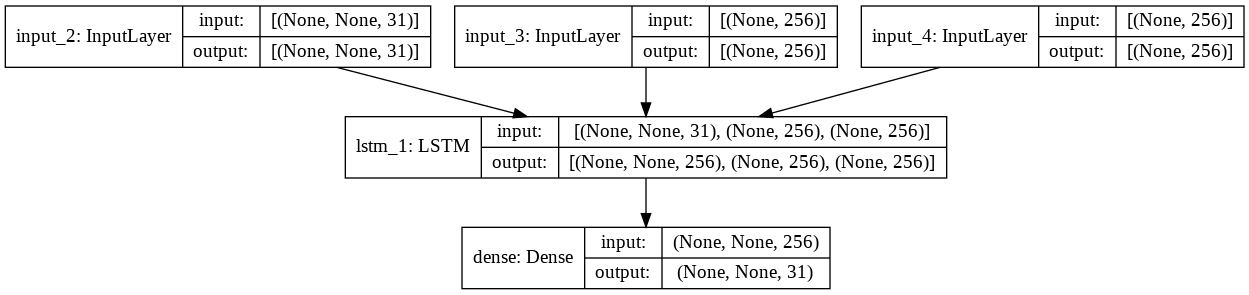

In [40]:
tf.keras.utils.plot_model(decoder_model, to_file='model_plot_dec.png', show_shapes=True, show_layer_names=True)

In [41]:
def predict_target(input_string):
  # convert for encoding 
  input_data = np.zeros((1, max_encoder_seq_length, num_encoder_tokens), dtype='float32')
  for t, char in enumerate(input_string):
    input_data[0, t, input_token_index[char]] = 1.

  # Encode the input as state vectors.
  states_value = encoder_model(input_data)

   # Generate empty target sequence of length 1.
  target_seq = np.zeros((1, 1, num_decoder_tokens), dtype='float32')
  # Populate the first character of target sequence with the start character.
  target_seq[0, 0, target_token_index['^']] = 1.0

  stop_condition = False
  decoded_sentence = ""

  while True:
    output_tokens, d_h, d_c = decoder_model.predict([target_seq] + states_value)
    # Sample a token
    sampled_token_index = np.argmax(output_tokens[0, -1, :])
    sampled_char = reverse_target_char_index[sampled_token_index]

    # Exit condition: either hit max length
    # or find stop character.
    if sampled_char == "$" or len(decoded_sentence) > max_decoder_seq_length:
      break
      
    decoded_sentence += sampled_char

    # Update the target sequence (of length 1).
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    target_seq[0, 0, sampled_token_index] = 1.0

    # Update states
    states_value = [d_h, d_c]
  return decoded_sentence

In [42]:
test_input = 'राजशेखर'
predicted_string = predict_target(test_input)
predicted_string

'raj'

In [43]:
test_input = 'शारजील'
predicted_string = predict_target(test_input)
predicted_string

'sharjee'